# KPA stance detection with only arguments

Stance detection of the KPA datasets using only arguments as input to train the model, without considering the main topic of each one

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from autocorrect import Speller
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

## 1. Import datasets

In [3]:
train_path = '../data/kpa/arguments_train.csv'
val_path = '../data/kpa/arguments_dev.csv'
test_path = '../data/kpa/arguments_test.csv'

plots_path = '../plots/kpa/'
models_path = '../models/kpa'

### Training set

In [4]:
train = pd.read_csv(train_path) 

In [5]:
train['topic'].nunique()

24

In [6]:
train.groupby(by=['topic', 'stance']).agg({'argument': 'count'}).reset_index().head()

,topic,stance,argument
0,Assisted suicide should be a criminal offence,-1,121
1,Assisted suicide should be a criminal offence,1,125
2,Homeschooling should be banned,-1,129
3,Homeschooling should be banned,1,115
4,The vow of celibacy should be abandoned,-1,112


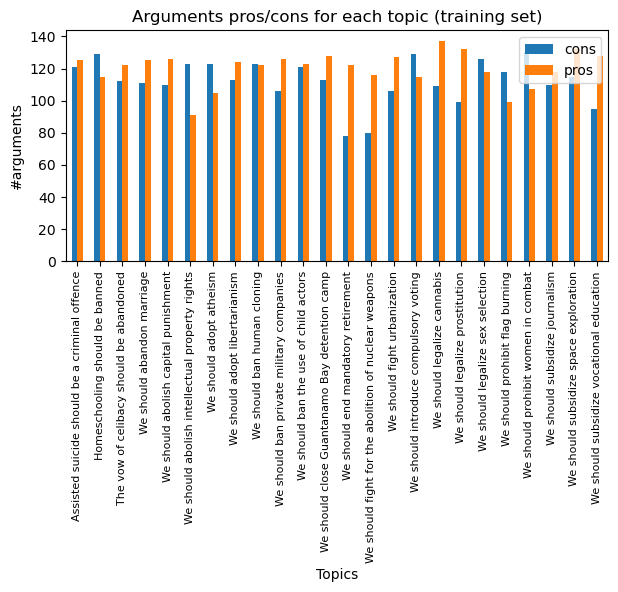

In [7]:
train_stats = train.groupby(by=['topic', 'stance']).agg({'argument': 'count'}).reset_index()
train_stats.pivot(index='topic', columns='stance', values='argument').rename(columns={-1: 'cons', 1: 'pros'}).plot(kind='bar', figsize=(7,3))
plt.title('Arguments pros/cons for each topic (training set)')
plt.ylabel('#arguments')
plt.xlabel('Topics')
plt.xticks(fontsize=8, rotation=90)
plt.legend(loc='upper right')
plt.savefig(plots_path+'kpa_train_topic_stats.png', bbox_inches ="tight")
plt.show()

### Validation set

In [8]:
val = pd.read_csv(val_path) 

In [9]:
val['topic'].nunique()

4

In [10]:
train.groupby(by=['topic', 'stance']).agg({'argument': 'count'}).reset_index().head()

,topic,stance,argument
0,Assisted suicide should be a criminal offence,-1,121
1,Assisted suicide should be a criminal offence,1,125
2,Homeschooling should be banned,-1,129
3,Homeschooling should be banned,1,115
4,The vow of celibacy should be abandoned,-1,112


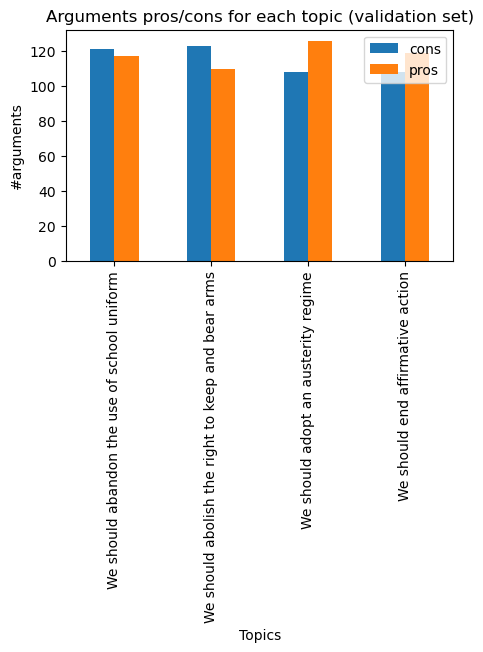

In [11]:
val_stats = val.groupby(by=['topic', 'stance']).agg({'argument': 'count'}).reset_index()
val_stats.pivot(index='topic', columns='stance', values='argument').rename(columns={-1: 'cons', 1: 'pros'}).plot(kind='bar', figsize=(5,3))
plt.title('Arguments pros/cons for each topic (validation set)')
plt.ylabel('#arguments')
plt.xlabel('Topics')
plt.xticks(fontsize=10, rotation=90)
plt.legend(loc='upper right')
plt.savefig(plots_path+'kpa_val_topic_stats.png', bbox_inches ="tight")
plt.show()

## 2. Preprocessing data

In [12]:
# lower
# remove extra whitespace
# tokenize
# spelling corrections
# remove stopwords (da verificare se migliora o peggiora)
# remove punctation
# lemmatization
# stemming 
# remove urls
# remove tags

## lemm e stem peggiorano accuracy e f1 score in NB

In [13]:
class PreprocessArguments:
    def __init__(self):
        self.spell = Speller(lang='en')
        self.stopwords_set = set(stopwords.words('english'))
        self.punct_remover = RegexpTokenizer(r'\w+')
        self.porter = PorterStemmer()
        self.wnl = WordNetLemmatizer()
    
    def preprocess(self, s):    
        # lowercase
        s = s.lower()
        # remove double whitespaces
        s = ' '.join(s.split())
        # tokenize
        s = word_tokenize(s)
        # spell correction
        s = [self.spell(word) for word in s]
        # remove punctuation
        s = self.punct_remover.tokenize(' '.join(s))
        # remove stopwords
        s = [word for word in s if word not in self.stopwords_set]
        # stemming
        #s = [self.porter.stem(word) for word in s]
        #lemmatization
        #s = [self.wnl.lemmatize(word) for word in s]
        
        return s

In [14]:
preproc = PreprocessArguments()

In [105]:
train['arg_tok'] = [preproc.preprocess(row['argument']) for idx, row in train.iterrows()]
val['arg_tok'] = [preproc.preprocess(row['argument']) for idx, row in val.iterrows()]

In [16]:
train.head()

,arg_id,argument,topic,stance,arg_tok
0,arg_0_0,`people reach their limit when it comes to the...,Assisted suicide should be a criminal offence,-1,"[people, reach, limit, comes, quality, life, a..."
1,arg_0_1,A patient should be able to decide when they h...,Assisted suicide should be a criminal offence,-1,"[patient, able, decide, enough, care]"
2,arg_0_2,a person has the right to end their suffering ...,Assisted suicide should be a criminal offence,-1,"[person, right, end, suffering, somebody, take..."
3,arg_0_3,a person should have the dignity to choose how...,Assisted suicide should be a criminal offence,-1,"[person, dignity, choose, die]"
4,arg_0_4,a person should have the right to be able to c...,Assisted suicide should be a criminal offence,-1,"[person, right, able, choose, want, live, die]"


In [17]:
count_vect = CountVectorizer(tokenizer=preproc.preprocess, lowercase=False, token_pattern=None)
count_fit = count_vect.fit_transform(train['argument'])

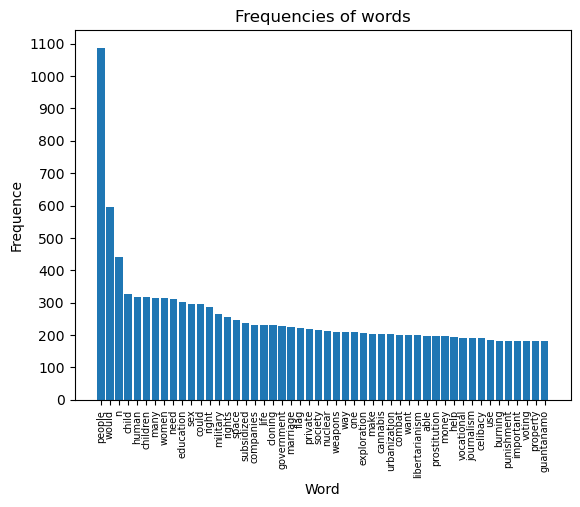

In [18]:
n = 50
count_sum = sorted(list(zip(count_fit.toarray().sum(axis=0), count_vect.get_feature_names_out())), reverse=True)
count_sum = count_sum[:n]
plt.bar([p[1] for p in count_sum], [p[0] for p in count_sum])
#plt.bar(range(len(count_sum)), [p[0] for p in count_sum])
plt.title('Frequencies of words')
plt.ylabel('Frequence')
plt.xlabel('Word')
plt.xticks(fontsize=7, rotation=90)
plt.yticks(np.arange(0,1200,100))
plt.savefig(plots_path+str(n)+'_token_frequencies.png', bbox_inches ="tight")
plt.show()

## 3. Classification

### 3.1 Baseline: Naive Bayes

In [78]:
def dummy_tokenizer(sentence):
    return sentence

In [79]:
scoring = ['accuracy', 'f1', 'precision', 'recall']

In [80]:
pipe = Pipeline([('preproc', TfidfVectorizer()), ('nb', MultinomialNB())])

In [109]:
params = [
    {'preproc': [TfidfVectorizer()],
     'preproc__tokenizer': [dummy_tokenizer],
     'preproc__preprocessor': [dummy_tokenizer],
     'preproc__token_pattern': [None],
     #'preproc__min_df': [1, 10, 20, 50, 100, 200],
     'preproc__min_df': [1, 2, 3, 4, 5],
     #'preproc__max_features': [None, 100, 200, 500],
     
     'nb': [MultinomialNB()],
     #'nb__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
     'nb__alpha': [390, 395, 400, 405, 410]
    }
]

In [110]:
clf = GridSearchCV(estimator=pipe, param_grid=params, scoring=scoring, refit='f1',
                   cv=5, return_train_score=True, n_jobs=1, verbose=10)

In [111]:
clf.fit(train['arg_tok'], train['stance'])

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5; 1/25] START nb=MultinomialNB(), nb__alpha=390, preproc=TfidfVectorizer(), preproc__min_df=1, preproc__token_pattern=None, preproc__tokenizer=<function word_tokenize at 0x7f5aa68badd0>
[CV 1/5; 1/25] END nb=MultinomialNB(), nb__alpha=390, preproc=TfidfVectorizer(), preproc__min_df=1, preproc__token_pattern=None, preproc__tokenizer=<function word_tokenize at 0x7f5aa68badd0>; accuracy: (train=0.516, test=0.517) f1: (train=0.681, test=0.681) precision: (train=0.516, test=0.517) recall: (train=1.000, test=1.000) total time=   0.6s
[CV 2/5; 1/25] START nb=MultinomialNB(), nb__alpha=390, preproc=TfidfVectorizer(), preproc__min_df=1, preproc__token_pattern=None, preproc__tokenizer=<function word_tokenize at 0x7f5aa68badd0>
[CV 2/5; 1/25] END nb=MultinomialNB(), nb__alpha=390, preproc=TfidfVectorizer(), preproc__min_df=1, preproc__token_pattern=None, preproc__tokenizer=<function word_tokenize at 0x7f5aa68badd0>; accuracy: (t

[CV 1/5; 4/25] END nb=MultinomialNB(), nb__alpha=390, preproc=TfidfVectorizer(), preproc__min_df=4, preproc__token_pattern=None, preproc__tokenizer=<function word_tokenize at 0x7f5aa68badd0>; accuracy: (train=0.517, test=0.517) f1: (train=0.682, test=0.681) precision: (train=0.517, test=0.517) recall: (train=1.000, test=1.000) total time=   0.6s
[CV 2/5; 4/25] START nb=MultinomialNB(), nb__alpha=390, preproc=TfidfVectorizer(), preproc__min_df=4, preproc__token_pattern=None, preproc__tokenizer=<function word_tokenize at 0x7f5aa68badd0>
[CV 2/5; 4/25] END nb=MultinomialNB(), nb__alpha=390, preproc=TfidfVectorizer(), preproc__min_df=4, preproc__token_pattern=None, preproc__tokenizer=<function word_tokenize at 0x7f5aa68badd0>; accuracy: (train=0.519, test=0.514) f1: (train=0.682, test=0.679) precision: (train=0.518, test=0.515) recall: (train=1.000, test=0.995) total time=   0.5s
[CV 3/5; 4/25] START nb=MultinomialNB(), nb__alpha=390, preproc=TfidfVectorizer(), preproc__min_df=4, preproc__

[CV 2/5; 7/25] END nb=MultinomialNB(), nb__alpha=395, preproc=TfidfVectorizer(), preproc__min_df=2, preproc__token_pattern=None, preproc__tokenizer=<function word_tokenize at 0x7f5aa68badd0>; accuracy: (train=0.518, test=0.514) f1: (train=0.682, test=0.679) precision: (train=0.517, test=0.515) recall: (train=1.000, test=0.995) total time=   0.6s
[CV 3/5; 7/25] START nb=MultinomialNB(), nb__alpha=395, preproc=TfidfVectorizer(), preproc__min_df=2, preproc__token_pattern=None, preproc__tokenizer=<function word_tokenize at 0x7f5aa68badd0>
[CV 3/5; 7/25] END nb=MultinomialNB(), nb__alpha=395, preproc=TfidfVectorizer(), preproc__min_df=2, preproc__token_pattern=None, preproc__tokenizer=<function word_tokenize at 0x7f5aa68badd0>; accuracy: (train=0.519, test=0.517) f1: (train=0.682, test=0.681) precision: (train=0.518, test=0.517) recall: (train=1.000, test=1.000) total time=   0.5s
[CV 4/5; 7/25] START nb=MultinomialNB(), nb__alpha=395, preproc=TfidfVectorizer(), preproc__min_df=2, preproc__

[CV 3/5; 10/25] END nb=MultinomialNB(), nb__alpha=395, preproc=TfidfVectorizer(), preproc__min_df=5, preproc__token_pattern=None, preproc__tokenizer=<function word_tokenize at 0x7f5aa68badd0>; accuracy: (train=0.520, test=0.517) f1: (train=0.683, test=0.681) precision: (train=0.518, test=0.517) recall: (train=1.000, test=1.000) total time=   0.6s
[CV 4/5; 10/25] START nb=MultinomialNB(), nb__alpha=395, preproc=TfidfVectorizer(), preproc__min_df=5, preproc__token_pattern=None, preproc__tokenizer=<function word_tokenize at 0x7f5aa68badd0>
[CV 4/5; 10/25] END nb=MultinomialNB(), nb__alpha=395, preproc=TfidfVectorizer(), preproc__min_df=5, preproc__token_pattern=None, preproc__tokenizer=<function word_tokenize at 0x7f5aa68badd0>; accuracy: (train=0.517, test=0.519) f1: (train=0.681, test=0.682) precision: (train=0.517, test=0.518) recall: (train=1.000, test=1.000) total time=   0.6s
[CV 5/5; 10/25] START nb=MultinomialNB(), nb__alpha=395, preproc=TfidfVectorizer(), preproc__min_df=5, prepr

[CV 4/5; 13/25] END nb=MultinomialNB(), nb__alpha=400, preproc=TfidfVectorizer(), preproc__min_df=3, preproc__token_pattern=None, preproc__tokenizer=<function word_tokenize at 0x7f5aa68badd0>; accuracy: (train=0.517, test=0.518) f1: (train=0.681, test=0.682) precision: (train=0.517, test=0.517) recall: (train=1.000, test=1.000) total time=   0.5s
[CV 5/5; 13/25] START nb=MultinomialNB(), nb__alpha=400, preproc=TfidfVectorizer(), preproc__min_df=3, preproc__token_pattern=None, preproc__tokenizer=<function word_tokenize at 0x7f5aa68badd0>
[CV 5/5; 13/25] END nb=MultinomialNB(), nb__alpha=400, preproc=TfidfVectorizer(), preproc__min_df=3, preproc__token_pattern=None, preproc__tokenizer=<function word_tokenize at 0x7f5aa68badd0>; accuracy: (train=0.518, test=0.516) f1: (train=0.682, test=0.681) precision: (train=0.517, test=0.516) recall: (train=1.000, test=1.000) total time=   0.6s
[CV 1/5; 14/25] START nb=MultinomialNB(), nb__alpha=400, preproc=TfidfVectorizer(), preproc__min_df=4, prepr

[CV 5/5; 16/25] END nb=MultinomialNB(), nb__alpha=405, preproc=TfidfVectorizer(), preproc__min_df=1, preproc__token_pattern=None, preproc__tokenizer=<function word_tokenize at 0x7f5aa68badd0>; accuracy: (train=0.517, test=0.516) f1: (train=0.681, test=0.681) precision: (train=0.517, test=0.516) recall: (train=1.000, test=1.000) total time=   0.6s
[CV 1/5; 17/25] START nb=MultinomialNB(), nb__alpha=405, preproc=TfidfVectorizer(), preproc__min_df=2, preproc__token_pattern=None, preproc__tokenizer=<function word_tokenize at 0x7f5aa68badd0>
[CV 1/5; 17/25] END nb=MultinomialNB(), nb__alpha=405, preproc=TfidfVectorizer(), preproc__min_df=2, preproc__token_pattern=None, preproc__tokenizer=<function word_tokenize at 0x7f5aa68badd0>; accuracy: (train=0.516, test=0.517) f1: (train=0.681, test=0.681) precision: (train=0.516, test=0.517) recall: (train=1.000, test=1.000) total time=   0.6s
[CV 2/5; 17/25] START nb=MultinomialNB(), nb__alpha=405, preproc=TfidfVectorizer(), preproc__min_df=2, prepr

[CV 1/5; 20/25] END nb=MultinomialNB(), nb__alpha=405, preproc=TfidfVectorizer(), preproc__min_df=5, preproc__token_pattern=None, preproc__tokenizer=<function word_tokenize at 0x7f5aa68badd0>; accuracy: (train=0.517, test=0.517) f1: (train=0.681, test=0.681) precision: (train=0.517, test=0.517) recall: (train=1.000, test=1.000) total time=   0.5s
[CV 2/5; 20/25] START nb=MultinomialNB(), nb__alpha=405, preproc=TfidfVectorizer(), preproc__min_df=5, preproc__token_pattern=None, preproc__tokenizer=<function word_tokenize at 0x7f5aa68badd0>
[CV 2/5; 20/25] END nb=MultinomialNB(), nb__alpha=405, preproc=TfidfVectorizer(), preproc__min_df=5, preproc__token_pattern=None, preproc__tokenizer=<function word_tokenize at 0x7f5aa68badd0>; accuracy: (train=0.519, test=0.512) f1: (train=0.682, test=0.677) precision: (train=0.518, test=0.514) recall: (train=1.000, test=0.991) total time=   0.5s
[CV 3/5; 20/25] START nb=MultinomialNB(), nb__alpha=405, preproc=TfidfVectorizer(), preproc__min_df=5, prepr

[CV 2/5; 23/25] END nb=MultinomialNB(), nb__alpha=410, preproc=TfidfVectorizer(), preproc__min_df=3, preproc__token_pattern=None, preproc__tokenizer=<function word_tokenize at 0x7f5aa68badd0>; accuracy: (train=0.518, test=0.514) f1: (train=0.682, test=0.679) precision: (train=0.517, test=0.515) recall: (train=1.000, test=0.995) total time=   0.6s
[CV 3/5; 23/25] START nb=MultinomialNB(), nb__alpha=410, preproc=TfidfVectorizer(), preproc__min_df=3, preproc__token_pattern=None, preproc__tokenizer=<function word_tokenize at 0x7f5aa68badd0>
[CV 3/5; 23/25] END nb=MultinomialNB(), nb__alpha=410, preproc=TfidfVectorizer(), preproc__min_df=3, preproc__token_pattern=None, preproc__tokenizer=<function word_tokenize at 0x7f5aa68badd0>; accuracy: (train=0.519, test=0.517) f1: (train=0.682, test=0.681) precision: (train=0.518, test=0.517) recall: (train=1.000, test=1.000) total time=   0.5s
[CV 4/5; 23/25] START nb=MultinomialNB(), nb__alpha=410, preproc=TfidfVectorizer(), preproc__min_df=3, prepr

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=1,
             param_grid=[{'nb': [MultinomialNB(alpha=400)],
                          'nb__alpha': [390, 395, 400, 405, 410],
                          'preproc': [TfidfVectorizer(token_pattern=None,
                                                      tokenizer=<function word_tokenize at 0x7f5aa68badd0>)],
                          'preproc__min_df': [1, 2, 3, 4, 5],
                          'preproc__token_pattern': [None],
                          'preproc__tokenizer': [<function word_tokenize at 0x7f5aa68badd0>]}],
             refit='f1', return_train_score=True,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=10)

In [112]:
clf.best_params_

{'nb': MultinomialNB(alpha=400),
 'nb__alpha': 400,
 'preproc': TfidfVectorizer(token_pattern=None,
                 tokenizer=<function word_tokenize at 0x7f5aa68badd0>),
 'preproc__min_df': 1,
 'preproc__token_pattern': None,
 'preproc__tokenizer': <function nltk.tokenize.word_tokenize(text, language='english', preserve_line=False)>}

In [113]:
#pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_f1')[['mean_test_f1', 'param_nb', 'param_preproc__min_df']][:50]

In [114]:
#pd.DataFrame(clf.cv_results_).to_csv(models_path+'nb_gridsearch.csv')

In [117]:
best_clf = clf.best_estimator_
best_clf.fit(train['arg_tok'], train['stance'])
pred_val = best_clf.predict(val['arg_tok'])

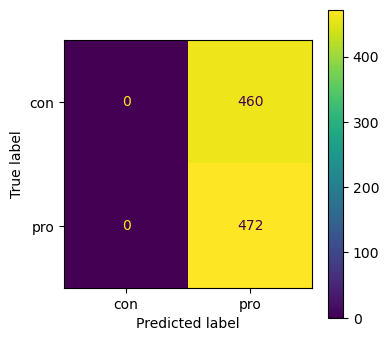

In [118]:
cm = confusion_matrix(val['stance'], pred_val)
# dictionary to map value of confusion matrix
class_dict = {-1: 'con', 1: 'pro'}
fig, ax = plt.subplots(figsize=(4,4))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_dict[c] for c in clf.classes_]).plot(ax=ax)

In [119]:
print(classification_report(val['stance'], pred_val))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       460
           1       0.51      1.00      0.67       472

    accuracy                           0.51       932
   macro avg       0.25      0.50      0.34       932
weighted avg       0.26      0.51      0.34       932



/home/sbaccile/anaconda3/envs/hlt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sbaccile/anaconda3/envs/hlt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sbaccile/anaconda3/envs/hlt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

### 3.2 SVM

In [122]:
def dummy_tokenizer(sentence):
    return sentence

In [123]:
scoring = ['accuracy', 'f1', 'precision', 'recall']

In [124]:
pipe = Pipeline([('preproc', TfidfVectorizer()), ('svm', SVC())])

In [173]:
params = [
    {'preproc': [TfidfVectorizer()],
     'preproc__tokenizer': [dummy_tokenizer],
     'preproc__preprocessor': [dummy_tokenizer],
     'preproc__token_pattern': [None],
     #'preproc__min_df': [1, 10, 20, 50, 100, 200],
     #'preproc__min_df': [1, 2, 3, 4, 5],
     'preproc__min_df': [1],
     
     'svm': [SVC()],
     #'svm__C': [0.1, 1, 2, 5, 10, 50],
     #'svm__C': np.arange(1,10,1),
     'svm__C': [1, 5, 10],
     'svm__kernel': ['poly'],
     #'svm__degree': [2, 3, 5, 8, 10],
     #'svm__degree': [8, 9, 10],
     'svm__degree': [8, 9],
     'svm__gamma': ['scale'],
     #'svm__class_weight': [None, 'balanced'],
    },
]

In [174]:
clf = GridSearchCV(estimator=pipe, param_grid=params, scoring=scoring, refit='f1',
                   cv=5, return_train_score=True, n_jobs=1, verbose=10)

In [186]:
clf.fit(train['arg_tok'], train['stance'])

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START preproc=TfidfVectorizer(preprocessor=<function dummy_tokenizer at 0x7f5a91beb760>,
                token_pattern=None,
                tokenizer=<function dummy_tokenizer at 0x7f5a91beb760>), preproc__min_df=1, preproc__preprocessor=<function dummy_tokenizer at 0x7f5a91beb760>, preproc__token_pattern=None, preproc__tokenizer=<function dummy_tokenizer at 0x7f5a91beb760>, svm=SVC(C=1, degree=8, kernel='poly'), svm__C=1, svm__degree=8, svm__gamma=scale, svm__kernel=poly
[CV 1/5; 1/6] END preproc=TfidfVectorizer(preprocessor=<function dummy_tokenizer at 0x7f5a91beb760>,
                token_pattern=None,
                tokenizer=<function dummy_tokenizer at 0x7f5a91beb760>), preproc__min_df=1, preproc__preprocessor=<function dummy_tokenizer at 0x7f5a91beb760>, preproc__token_pattern=None, preproc__tokenizer=<function dummy_tokenizer at 0x7f5a91beb760>, svm=SVC(C=1, degree=8, kernel='poly'), svm__C=1, svm__deg

[CV 3/5; 2/6] END preproc=TfidfVectorizer(preprocessor=<function dummy_tokenizer at 0x7f5a91beb760>,
                token_pattern=None,
                tokenizer=<function dummy_tokenizer at 0x7f5a91beb760>), preproc__min_df=1, preproc__preprocessor=<function dummy_tokenizer at 0x7f5a91beb760>, preproc__token_pattern=None, preproc__tokenizer=<function dummy_tokenizer at 0x7f5a91beb760>, svm=SVC(C=1, degree=8, kernel='poly'), svm__C=1, svm__degree=9, svm__gamma=scale, svm__kernel=poly; accuracy: (train=1.000, test=0.517) f1: (train=1.000, test=0.682) precision: (train=1.000, test=0.517) recall: (train=1.000, test=1.000) total time=   1.9s
[CV 4/5; 2/6] START preproc=TfidfVectorizer(preprocessor=<function dummy_tokenizer at 0x7f5a91beb760>,
                token_pattern=None,
                tokenizer=<function dummy_tokenizer at 0x7f5a91beb760>), preproc__min_df=1, preproc__preprocessor=<function dummy_tokenizer at 0x7f5a91beb760>, preproc__token_pattern=None, preproc__tokenizer=<funct

[CV 1/5; 4/6] END preproc=TfidfVectorizer(preprocessor=<function dummy_tokenizer at 0x7f5a91beb760>,
                token_pattern=None,
                tokenizer=<function dummy_tokenizer at 0x7f5a91beb760>), preproc__min_df=1, preproc__preprocessor=<function dummy_tokenizer at 0x7f5a91beb760>, preproc__token_pattern=None, preproc__tokenizer=<function dummy_tokenizer at 0x7f5a91beb760>, svm=SVC(C=1, degree=8, kernel='poly'), svm__C=5, svm__degree=9, svm__gamma=scale, svm__kernel=poly; accuracy: (train=1.000, test=0.517) f1: (train=1.000, test=0.682) precision: (train=1.000, test=0.517) recall: (train=1.000, test=1.000) total time=   1.9s
[CV 2/5; 4/6] START preproc=TfidfVectorizer(preprocessor=<function dummy_tokenizer at 0x7f5a91beb760>,
                token_pattern=None,
                tokenizer=<function dummy_tokenizer at 0x7f5a91beb760>), preproc__min_df=1, preproc__preprocessor=<function dummy_tokenizer at 0x7f5a91beb760>, preproc__token_pattern=None, preproc__tokenizer=<funct

[CV 4/5; 5/6] END preproc=TfidfVectorizer(preprocessor=<function dummy_tokenizer at 0x7f5a91beb760>,
                token_pattern=None,
                tokenizer=<function dummy_tokenizer at 0x7f5a91beb760>), preproc__min_df=1, preproc__preprocessor=<function dummy_tokenizer at 0x7f5a91beb760>, preproc__token_pattern=None, preproc__tokenizer=<function dummy_tokenizer at 0x7f5a91beb760>, svm=SVC(C=1, degree=8, kernel='poly'), svm__C=10, svm__degree=8, svm__gamma=scale, svm__kernel=poly; accuracy: (train=1.000, test=0.529) f1: (train=1.000, test=0.687) precision: (train=1.000, test=0.523) recall: (train=1.000, test=1.000) total time=   1.8s
[CV 5/5; 5/6] START preproc=TfidfVectorizer(preprocessor=<function dummy_tokenizer at 0x7f5a91beb760>,
                token_pattern=None,
                tokenizer=<function dummy_tokenizer at 0x7f5a91beb760>), preproc__min_df=1, preproc__preprocessor=<function dummy_tokenizer at 0x7f5a91beb760>, preproc__token_pattern=None, preproc__tokenizer=<func

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc', TfidfVectorizer()),
                                       ('svm', SVC())]),
             n_jobs=1,
             param_grid=[{'preproc': [TfidfVectorizer(preprocessor=<function dummy_tokenizer at 0x7f5a91beb760>,
                                                      token_pattern=None,
                                                      tokenizer=<function dummy_tokenizer at 0x7f5a91beb760>)],
                          'preproc__min_df': [1],
                          'preproc__preprocessor': [<function dummy_tokenizer at 0x7f5a91beb760>],
                          'preproc__token_pattern': [None],
                          'preproc__tokenizer': [<function dummy_tokenizer at 0x7f5a91beb760>],
                          'svm': [SVC(C=1, degree=8, kernel='poly')],
                          'svm__C': [1, 5, 10], 'svm__degree': [8, 9],
                          'svm__gamma': ['scale'], 'svm__kernel': ['poly']}],
             refit='f1', return_train_score=True,
             scoring=['accuracy', 'f1', 'precision', 'recall'], verbose=10)

In [187]:
clf.best_params_

{'preproc': TfidfVectorizer(preprocessor=<function dummy_tokenizer at 0x7f5a91beb760>,
                 token_pattern=None,
                 tokenizer=<function dummy_tokenizer at 0x7f5a91beb760>),
 'preproc__min_df': 1,
 'preproc__preprocessor': <function __main__.dummy_tokenizer(sentence)>,
 'preproc__token_pattern': None,
 'preproc__tokenizer': <function __main__.dummy_tokenizer(sentence)>,
 'svm': SVC(C=1, degree=8, kernel='poly'),
 'svm__C': 1,
 'svm__degree': 8,
 'svm__gamma': 'scale',
 'svm__kernel': 'poly'}

In [188]:
#pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_f1')[['mean_test_f1', 'param_svm__C', 'param_svm__degree', 'param_preproc__min_df']][:50]

In [189]:
#pd.DataFrame(clf.cv_results_).to_csv(models_path+'svc_gridsearch_1.csv')

In [191]:
best_clf = clf.best_estimator_
best_clf.fit(train['arg_tok'], train['stance'])
pred_val = best_clf.predict(val['arg_tok'])

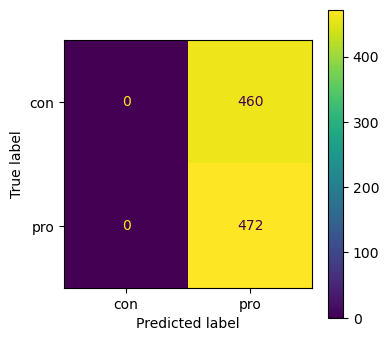

In [192]:
cm = confusion_matrix(val['stance'], pred_val)
# dictionary to map value of confusion matrix
class_dict = {-1: 'con', 1: 'pro'}
fig, ax = plt.subplots(figsize=(4,4))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_dict[c] for c in clf.classes_]).plot(ax=ax)

In [ ]:
print(classification_report(val['stance'], pred_val))

### 3.3 BERT